Generate RMSD speed figure for JOSS paper.

Prerequisites:

- Create a python environment with `zarrtraj` installed (see [installation](https://zarrtraj.readthedocs.io/en/latest/installation.html#installation))
- Install `ipykernel` to be able to run jupyter notebooks
- Install `matplotlib` for plotting
- Install `MDAnalysisData` for the sample topology and trajectory data
- Install `dask` for the parallelized analysis benchmark
- Install `boto3` only if you are reproducing the H5MD from S3 part of the benchmark


### 1. Download PDB topology and (un-aligned) XTC trajectory using MDAnalysisData


In [16]:
import MDAnalysisData

dataset = MDAnalysisData.yiip_equilibrium.fetch_yiip_equilibrium_long(data_home="../zarrtraj/data")

### 2. Align and write trajectory files in different formats

Write to disk:

- H5MD on disk
- ZarrMD on disk
- XTC on disk

These scripts are meant to be run from root of the cloned zarrtraj repository, from the python environment described above:

```python
# this script must be run first, since the other two rely on the XTC aligned traj
python zarrtraj/data/write_aligned_yiip_xtc.py
python zarrtraj/data/write_aligned_compressed_disk_h5md.py
python zarrtraj/data/write_aligned_compressed_disk_zarrmd.py
```


Additionally, write to cloud:

- H5MD on S3
- ZarrMD on S3

The listed bucket URL is not publicly readable or writeable due to cost, but follow [the guide on writing to cloud storage](https://zarrtraj.readthedocs.io/en/latest/walkthrough.html#writing-trajectories-to-cloud-storage) if you're interested in reproducing this part of the benchmark with your own bucket.

```python
python zarrtraj/data/write_aligned_compressed_s3_zarrmd.py
# since zarrtraj doesn't allow writing H5MD files directly to cloud buckets, below script uploads the trajectory created by "write_aliged_compressed_disk_h5md.py"
python zarrtraj/data/write_aligned_compressed_s3_h5md.py
```


### 3. Benchmark method


In [17]:
from MDAnalysis.analysis.rms import RMSD
import time

def time_backbone_RMSD(u, **kwargs):
    start = time.time()
    R = RMSD(u, u, select="backbone")
    R.run(**kwargs)
    stop = time.time()

    return stop - start

### 4. Load disk data and run disk benchmarks


In [18]:
import MDAnalysis as mda
import zarrtraj

TOPOL = "../zarrtraj/data/yiip_equilibrium/YiiP_system.pdb"
H5MD_DISK_TRAJ = "../zarrtraj/data/yiip_aligned_compressed.h5md"
ZARRMD_TRAJ_DISK = "../zarrtraj/data/yiip_aligned_compressed.zarrmd"
XTC_TRAJ = "../zarrtraj/data/yiip_equilibrium/YiiP_system_90ns_center_aligned.xtc"

xtc_u = mda.Universe(TOPOL, XTC_TRAJ)
h5md_disk_u = mda.Universe(TOPOL, H5MD_DISK_TRAJ)
zarrmd_disk_u = mda.Universe(TOPOL, ZARRMD_TRAJ_DISK)


In [ ]:
## Dask 

### XTC 

xtc_time_dask = time_backbone_RMSD(xtc_u, backend="dask", n_workers=4)

### ZarrMD, disk

zarrmd_disk_time_dask = time_backbone_RMSD(zarrmd_disk_u, backend="dask", n_workers=4)

## H5MD, disk

h5md_disk_time_dask = time_backbone_RMSD(h5md_disk_u, backend="dask", n_workers=4)

## Serial

## XTC

xtc_time_serial = time_backbone_RMSD(xtc_u, backend="serial")

## ZarrMD, disk

zarrmd_disk_time_serial = time_backbone_RMSD(zarrmd_disk_u, backend="serial")

## H5MD, disk

h5md_disk_time_serial = time_backbone_RMSD(h5md_disk_u, backend="serial")



### 5. Load S3 data and perform cloud benchmarks


In [30]:
import os
import MDAnalysis as mda
import zarrtraj

os.environ["S3_REGION_NAME"] = "us-west-1"
os.environ["AWS_PROFILE"] = "sample_profile"

TOPOL = "../zarrtraj/data/yiip_equilibrium/YiiP_system.pdb"
H5MD_S3_TRAJ = "s3://zarrtraj-test-data/yiip_aligned_compressed.h5md"
ZARRMD_TRAJ_S3 = "s3://zarrtraj-test-data/yiip_aligned_compressed.zarrmd"

h5md_s3_u = mda.Universe(TOPOL, H5MD_S3_TRAJ)
zarrmd_s3_u = mda.Universe(TOPOL, ZARRMD_TRAJ_S3)

In [ ]:
## ZarrMD, S3

zarrmd_s3_time_dask = time_backbone_RMSD(zarrmd_s3_u, backend="dask", n_workers=4)

## H5MD, S3

h5md_s3_time_dask = time_backbone_RMSD(h5md_s3_u, backend="dask", n_workers=4)

## ZarrMD, S3

zarrm_s3_time_serial = time_backbone_RMSD(zarrmd_s3_u, backend="serial")

## H5MD, S3

h5md_s3_time_serial = time_backbone_RMSD(h5md_s3_u, backend="serial")

### 6. Create figure


0.5079891562461853
1.5919220209121705
4.785086027781168
15.081525770823161
0.8399416049321492
1.9880372802416484
5.266235820452372
19.71386777162552
2.5871417999267576
5.6665968219439184


/tmp/ipykernel_2862458/849001616.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha='right')


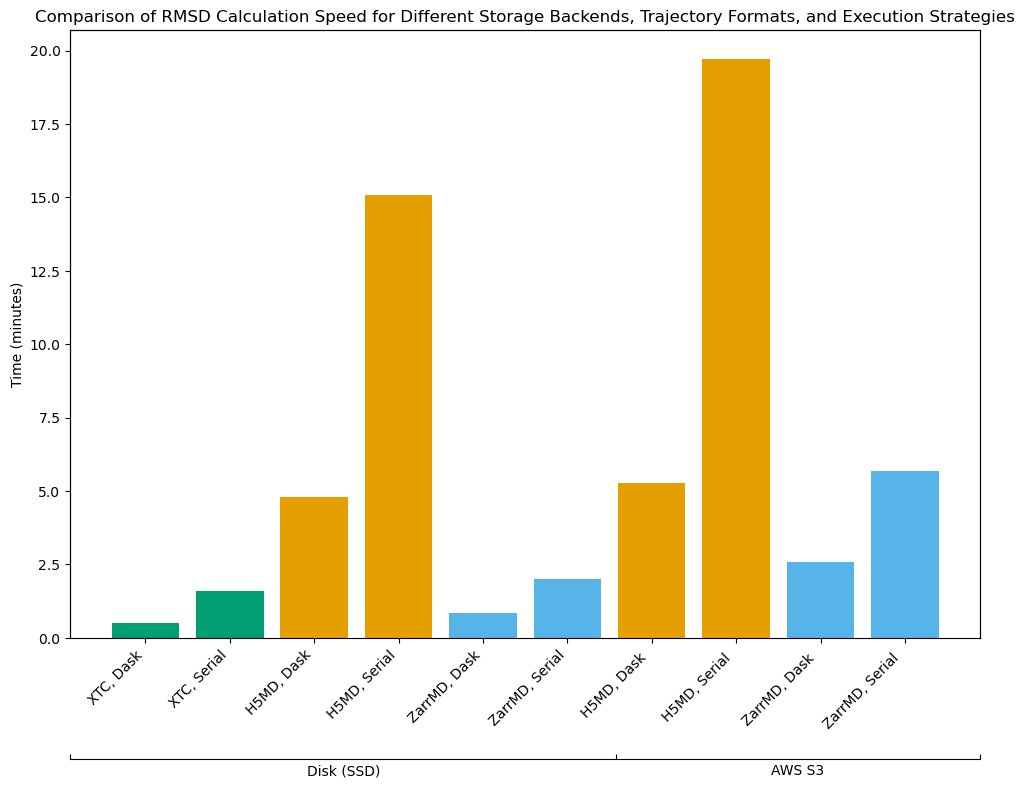

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

labels = [
'XTC, Dask', 
'XTC, Serial', 
'H5MD, Dask', 
'H5MD, Serial', 
'ZarrMD, Dask', 
'ZarrMD, Serial', 
# '',
'H5MD, Dask ', 
'H5MD, Serial ', 
'ZarrMD, Dask ', 
'ZarrMD, Serial ']

# values extracted from run of above benchmarks on Oct 3, 2024
values = [
# XTC, disk
30.479349374771118 / 60.0,
95.51532125473022 / 60.0,
# H5MD, disk
287.1051616668701 / 60.0,
904.8915462493896 / 60.0,
# ZarrMD, disk
50.396496295928955 / 60.0,
119.2822368144989 / 60.0,
# Sep
# 0,
# H5MD, S3
315.97414922714233 / 60.0,
1182.8320662975311 / 60.0,
# ZarrMD, S3
155.22850799560547 / 60.0,
339.99580931663513 / 60.0,
]

for value in values:
    print(value)
colors = [
'#009e73', '#009e73', 
'#e69f00', '#e69f00', 
'#56b4e9', '#56b4e9', 
# 'none',
'#e69f00', '#e69f00', 
'#56b4e9', '#56b4e9']


fig1, ax1 = plt.subplots(figsize=(12, 8))
ax1.bar(labels, values, color=colors)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylabel('Time (minutes)')

# Axis 2 (labels)
ax2 = ax1.twiny()
ax2.spines["bottom"].set_position(("axes", -0.20))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.0, 0.6, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.3, 0.8]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['Disk (SSD)', 'AWS S3']))



plt.title('Comparison of RMSD Calculation Speed for Different Storage Backends, Trajectory Formats, and Execution Strategies')

plt.tight_layout()

plt.savefig('RMSD.png')
plt.show()